## 利用DMFF构建长短程分离力场PhyNEO <a id ='3'></a>
参考链接：
1. Chen, Junmin, and Kuang Yu. "PhyNEO: A Neural-Network-Enhanced Physics-Driven Force Field Development Workflow for Bulk Organic Molecule and Polymer Simulations." Journal of Chemical Theory and Computation 20.1 (2023): 253-265. https://pubs.acs.org/doi/full/10.1021/acs.jctc.3c01045
2. https://github.com/Jeremydream/PhyNEO

本案例主要由陈俊敏贡献

In [6]:
# ! git clone https://github.com/Jeremydream/PhyNEO.git
! git clone https://gitee.com/jeremydream62/PhyNEO.git
! git config --global --add safe.directory `pwd`/PhyNEO

fatal: destination path 'PhyNEO' already exists and is not an empty directory.


在这一案例中，我们将展示如何利用DMFF训练和推理精细构建神经网络和物理模型的混合力场PhyNEO，也属于自下而上bottom-up拟合。

下面我们进入工作文件夹

In [9]:
import os
current_directory = os.getcwd()  # 获取当前文件夹路径
print(current_directory)
os.chdir(os.path.join("PhyNEO/notebook/peo"))
print(os.getcwd())

/personal/github/PhyNEO/notebook/PhyNEO/notebook/peo


FileNotFoundError: [Errno 2] No such file or directory: 'PhyNEO/notebook/peo'

In [10]:
!git config -l

safe.directory=/data/electrolyte-dmff
safe.directory=/data/DMFF/DMFF
safe.directory=/personal/DMFF/DMFF
safe.directory=/personal/github/test/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/peo/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/peo/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/peo/PhyNEO
safe.directory=/personal/github/test/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/PhyNEO
safe.directory=/personal/github/PhyNEO/notebook/PhyNEO
user.email=dreamchen62@gmail.com
user.name=Jeremydream
http.sslverify=false
http.postbuffer=1048576000
http.proxy=http://ga.dp.tech:8118
https.proxy=http://ga.dp.tech:8118
core.repositoryformatversion=0
core.filemode=true
core.bare=false
core.logallrefupdates=true
remote.origin.url=https://gitee.com/jeremydream62/PhyNEO.git
remote.origin.fetch=+refs/head

In [ ]:
!lbg config account 

Notice: enter email/phone and password to use LBG Utility.  Set password at Bohrium Personal Center if not yet done.
email/phone number current: [chenjm21@mails.tsinghua.edu.cn]: 

In [4]:
import sys
import numpy as np
import openmm
from openmm import *
from openmm import app, unit
import jax
import jax_md
import jax.numpy as jnp
import dmff
from dmff.api import Hamiltonian
from dmff.common import nblist
from dmff.optimize import MultiTransform, genOptimizer
import pickle
import time
from jax import value_and_grad, jit, vmap
import optax
# 依赖


/opt/mamba/lib/python3.10/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


### 3.1 问题介绍 <a id ='3-1'></a>

PhyNEO力场将分子相互作用分为键能作用和非键能作用。
物理驱动的非键合模型（$E_{lr}^{nb}+E_{sr}^{nb}$），ML短程非键校正（$E_{sr，\text{ML}}^{nb}$）和sGNN成键模型（$E_\text{sGNN}^{bond}$），在这里我们暂时抛弃掉ML短程非键校正部份，以聚氧化乙烯（PEO）为例进行初步力场的构建，即：

$$
\begin{align}
\begin{cases}
E&=E^{n b}+E_\text{sGNN}^{b o n d} \\
E^{n b}&=E_{l r}^{n b}+E_{s r}^{n b}
\end{cases}
\end{align}
$$

<img src="https://i.postimg.cc/G2PKNwb8/fig-1.png" width="500" height="500" />
<img src="https://gitee.com/jeremydream62/PhyNEO/raw/main/notebook/workflow.png" width="500" height="500" />

在进行Bottom-up拟合短程相互作用力之前，我们先通过camcasp拿到包括长程参数在内的forcefield.xml文件，这一步可以参考我们在PhyNEO github给出的例子。

如图我们可以通过一对PEO分子的长程扫描得知，当两个分子间隔一定距离时，多极矩可极化物理模型可以精确描述长程相互作用。

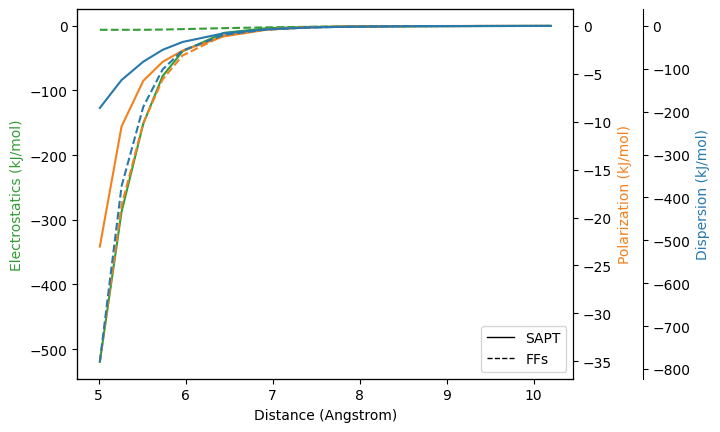

In [5]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import MDAnalysis as mda

def get_dimer(pdb):
    u = mda.Universe(pdb)
    n_atoms = len(u.atoms)
    monA = u.atoms.fragments[0].atoms
    monB = u.atoms.fragments[1].atoms
    return u, monA, monB

def gen_center_scan(u, monA, monB, posA, posB):
    monA.positions = posA
    monB.positions = posB
    dr_com = monB.center_of_mass() - monA.center_of_mass()
    dn_com = np.linalg.norm(dr_com)
    return dn_com

def gen_scan(u, monA, monB, posA, posB):
    dr_com = posA - posB
    dn_com = np.linalg.norm(dr_com, axis=1)
    return np.min(dn_com)

with open('data.pickle', 'rb') as ifile:
    data_sapt = pickle.load(ifile)

with open('data_lr.pickle', 'rb') as ifile:
    data_lr = pickle.load(ifile)

batch = list(data_sapt)[0]
dref = data_sapt[batch]
dff = data_lr[batch]

u, monA, monB = get_dimer('peo1_dimer.pdb')

drange = np.arange(len(dff['tot']))
dns = []
for i in drange:
    posA = dref['posA'][i]
    posB = dref['posB'][i]
    dn = gen_scan(u, monA, monB, posA, posB)
    dns.append(dn)
    # print(dn)

colors = ['#349d35', '#f2811d', '#2779ac', '#c72f2f']
column_names = ['Electrostatics', 'Polarization',  'Dispersion', 'Total']
fig, ax = plt.subplots()
comps = ['es', 'pol', 'disp']
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 50)) 
axs = [ax, ax2, ax3]
for j, comp in enumerate(comps):
    axs[j].plot(dns, dref[comp], color=colors[j], label=comp+'-sapt')
    axs[j].plot(dns, dff[comp], '--', color=colors[j], label=comp+'-ff')
    axs[j].set_ylabel(f"{column_names[j]} (kJ/mol)", color=colors[j])

# Create a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], linestyle='--', color='k', lw=1)]

ax.set_xlabel("Distance (Angstrom)")
ax.legend(custom_lines, ['SAPT', 'FFs'], loc='lower right')

plt.show()

接下来我们可以扣除长程进行短程非键作用的拟合。

Bottom-up拟合的主要目标是第一性原理计算的能量和受力，这一目标函数的定义相对简单。我们先以拟合两个PEO dimer之间的Pauli Exchange相互作用为例子，再拓展到一个完整PhyNEO力场的构建：

![s](https://i.postimg.cc/3xs7wMwW/image.png)

这一体系的分子间交换排斥项可以写成如下形式：

$$
\begin{align}
\begin{cases}
E_{ex} & =  \sum_{i<j} A_{ij}\left(\frac{1}{3}(B_{ij}r)^2 + B_{ij}r + 1\right) \exp(-B_{ij}r) \\
A_{ij} & = A_i \cdot A_j \\
B_{ij} & = \sqrt{B_i \cdot B_j}
\end{cases}
\end{align}
$$

中拟合目标是SAPT第一性原理方法计算得到的exchange energy。根据过去经验，这一拟合中的prefactor（$A$）和exponents（$B$）呈现出比较强的关联，较容易出现过拟合，得到不太合理的参数。在这里我们试图利用ML中的ADAM算法进行优化，希望能得到物理上比较合理的参数。整个体系有5个原子类型，按照XML中的定义顺序分别为：

C1, H1, O, C2, H2

所有原子参数($A_i$和$B_i$)也将按照此顺序排列。

### 3.2 势函数定义 <a id ='3-2'></a>
我们定义相关的`Hamiltonian`（我们将对dimer和两个monomer分别定义不同的`Hamiltonian`和势能函数）：

In [6]:
ff = 'forcefield.xml'
pdb_AB = app.PDBFile('peo1_dimer.pdb')
pdb_A = app.PDBFile('peo1.pdb')
pdb_B = app.PDBFile('peo1.pdb')
H_AB = Hamiltonian(ff)
H_A = Hamiltonian(ff)
H_B = Hamiltonian(ff)

并得到相关势能函数：

In [7]:
rc = 1.45

pots_AB = H_AB.createPotential(pdb_AB.topology, nonbondedCutoff=rc*unit.nanometer, nonbondedMethod=app.CutoffPeriodic, ethresh=1e-4)
pots_A = H_A.createPotential(pdb_A.topology, nonbondedCutoff=rc*unit.nanometer, nonbondedMethod=app.CutoffPeriodic, ethresh=1e-4)
pots_B = H_B.createPotential(pdb_B.topology, nonbondedCutoff=rc*unit.nanometer, nonbondedMethod=app.CutoffPeriodic, ethresh=1e-4)
pot_ex_AB = pots_AB.dmff_potentials['SlaterExForce']
pot_ex_A = pots_A.dmff_potentials['SlaterExForce']
pot_ex_B = pots_B.dmff_potentials['SlaterExForce']

注意到这里`forcefield.xml`中是一个完整的力场，包含相当多的components，在这里我们只关心exchange部分，因此我们仅仅取出其中相关的势能函数。

在后续损失函数的计算中，我们会把一个一个的minibatch作为输入，因此需要一次性计算一个minibatch中多个结构的能量。为加快速度，我们可以利用`jax.vmap`将单个势能计算函数转化为一个矢量化的能量计算函数：

In [8]:
pot_ex_AB_v = jit(vmap(pot_ex_AB, in_axes=(0, None, None, None), out_axes=(0)))
pot_ex_A_v = jit(vmap(pot_ex_A, in_axes=(0, None, None, None), out_axes=(0)))
pot_ex_B_v = jit(vmap(pot_ex_B, in_axes=(0, None, None, None), out_axes=(0)))


在这一过程中，我们指定对第一个变量（也就是`positions`）的第一个轴做向量化。

### 3.3 准备势函数的输入（近邻表等） <a id ='3-3'></a>

接下来，我们准备这些势能函数所需要的输入，其中最重要的是neighbor list。对于只有两个分子的简单体系，我们可以将`rc`设置的比较大，以包含所有对相互作用，这样我们就可以不必因为结构变化而更新neighbor list，从而加快计算速度。

我们首先获得初始的结构以及盒子大小：

<!-- （**WARNING**: 在`ADMP`模块中的所有后端函数的输入均以Angstrom为单位，这与`classical`模块不同：在`classical`模块中默认单位是nm） -->

In [9]:
rc = 1.45

pos_AB0 = jnp.array(pdb_AB.positions._value) 
n_atoms = len(pos_AB0)
n_atoms_A = n_atoms // 2
n_atoms_B = n_atoms // 2
pos_A0 = jnp.array(pdb_AB.positions._value[:n_atoms_A]) 
pos_B0 = jnp.array(pdb_AB.positions._value[n_atoms_A:n_atoms]) 
box = jnp.array(pdb_AB.topology.getPeriodicBoxVectors()._value) 

然后利用初始结构构造所有atom pair的列表：

In [10]:
nbl_AB = nblist.NeighborList(box, rc, pots_AB.meta['cov_map'])
nbl_AB.allocate(pos_AB0)
pairs_AB = nbl_AB.pairs
nbl_A = nblist.NeighborList(box, rc, pots_A.meta['cov_map'])
nbl_A.allocate(pos_A0)
pairs_A = nbl_A.pairs
nbl_B = nblist.NeighborList(box, rc, pots_B.meta['cov_map'])
nbl_B.allocate(pos_B0)
pairs_B = nbl_B.pairs

接下来获取初始参数，作为优化的起点：

In [11]:
params = H_AB.getParameters().parameters

# Make printing parameters a little more readable
def parameter_shapes(params):
    return jax.tree_util.tree_map(lambda p: p.shape, params)

print(parameter_shapes(params))


{'ADMPDispPmeForce': {'C10': (5,), 'C6': (5,), 'C8': (5,)}, 'ADMPPmeForce': {'Q_local': (6, 9), 'pol': (5,), 'thole': (5,)}, 'QqTtDampingForce': {'B': (5,), 'Q': (5,)}, 'SlaterDampingForce': {'B': (5,), 'C10': (5,), 'C6': (5,), 'C8': (5,)}, 'SlaterDhfForce': {'A': (5,), 'B': (5,)}, 'SlaterExForce': {'A': (5,), 'B': (5,)}, 'SlaterSrDispForce': {'A': (5,), 'B': (5,)}, 'SlaterSrEsForce': {'A': (5,), 'B': (5,)}, 'SlaterSrPolForce': {'A': (5,), 'B': (5,)}}


### 3.4 载入数据 <a id ='3-4'></a>

In [12]:
with open('data_sr.pickle', 'rb') as ifile:
    data = pickle.load(ifile)

这里的数据集来自第一性原理（SAPT）计算，由50个dimer scan组成（每个scan由一个固定的scan id标记，其中包含12个结构），每个dimer scan有12个结构，我们可以看一下数据集的存储结构：

In [13]:
# print all scan ids (sid)
print(data.keys())

dict_keys(['180', '240', '320', '200', '220', '480', '000', '020', '040', '060', '080', '100', '120', '500', '140', '160', '260', '280', '300', '340', '360', '380', '400', '420', '440', '460', '520', '540', '560', '580', '600', '620', '640', '660', '680', '700', '720', '740', '760', '780', '800', '820', '840', '860', '880', '900', '920', '940', '960', '980'])


我们仅使用其中的exchange energy数据

In [14]:
# Check out the exchange energy of the first scan
scan_res = data['000']
print(scan_res['ex'])

[1.39466427e+02 8.08116248e+01 4.56703077e+01 2.52853430e+01
 1.37681072e+01 3.93215704e+00 1.08843093e+00 2.95647950e-01
 7.99345500e-02 1.13576600e-02 1.64950000e-03 2.42900000e-04]


In [15]:
# Check out the structure of this scan
print(scan_res['posA'].shape)

(12, 16, 3)


在接下来的拟合中，我们将把所有scan的顺序打乱，然后将每一个scan的数据作为一个minibatch输入，利用ADAM训练参数。

### 3.5 定义损失函数 <a id ='3-5'></a>

针对分子间的交换排斥相互作用，定义如下能量损失函数：

In [16]:
 @jit
 def MSELoss(params, scan_res):
     '''
     The weighted mean squared error loss function
     Conducted for each scan
     '''

     E_ref = scan_res['ex']
     E_tot_full = scan_res['tot_full']
     kT = 2.494 # 300 K = 2.494 kJ/mol
     weights_pts = jnp.piecewise(E_tot_full, [E_tot_full<25, E_tot_full>=25], [lambda x: jnp.array(1.0), lambda x: jnp.exp(-(x-25)/kT)])
     npts = len(weights_pts)

     pos_A = jnp.array(scan_res['posA']) * 0.1
     pos_B = jnp.array(scan_res['posB']) * 0.1
     pos_AB = jnp.concatenate([pos_A, pos_B], axis=1)

     E_AB = pot_ex_AB_v(pos_AB, box, pairs_AB, params)
     E_A = pot_ex_A_v(pos_A, box, pairs_A, params)
     E_B = pot_ex_B_v(pos_B, box, pairs_B, params)
     dE = E_AB - E_A - E_B - E_ref
     MSE = jnp.sum(dE**2 * weights_pts) / jnp.sum(weights_pts)

     return MSE
    
MSELoss_grad = jit(value_and_grad(MSELoss, argnums=(0)))

在这个函数中，我们为每个数据点加上了一个统计权重：

$$
W(E_{tot}) = \begin{cases}
\begin{align}
&1.0  & &\text{ if } E_{tot} < 25 \\
&\exp\left(-\frac{E_{tot} - 25}{kT}\right) & &\text{ otherwise}
\end{align}
\end{cases}
$$

这样，我们可以忽略掉那些总能量过高，因此在实际模拟中并不重要的点。

### 3.6 能量优化 <a id ='3-6'></a>

接下来，我们初始化我们的优化器：

In [17]:
multiTrans = MultiTransform(params)
multiTrans["SlaterExForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterExForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans.finalize()
grad_transform = optax.multi_transform(multiTrans.transforms, multiTrans.labels)
opt_state = grad_transform.init(params)
print(params["SlaterExForce"]["B"])

[39.77508 45.96271 46.37414 38.31504 46.32228]


然后开始我们的优化循环，将所有数据优化一遍为一个epoch，每个epoch结束之后我们将参数保存成一个pickle文件。

In [18]:
# the log file
n_epochs = 50

from tqdm import tqdm

with open("log", "w") as logfile:
    sids = sids = np.array(list(data.keys()))
    for i_epoch in tqdm(range(n_epochs)):
        np.random.shuffle(sids)
        for sid in sids:
            loss, g = MSELoss_grad(params, data[sid])
            print(loss, file=logfile)
            # print(params["SlaterExForce"]["B"])
            logfile.flush()
            updates, opt_state = grad_transform.update(g, opt_state, params=params)
            params = optax.apply_updates(params, updates)
        with open('params.pickle', 'wb') as ofile:
            pickle.dump(params, ofile)

100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


我们先做50个epoch，当然我们还可以继续优化下去，取得更好的结果。我们可以检查优化所得到的$B$参数在物理上是基本合理的：
依次是对应C1, H1, O, C2, H2的参数B，H原子参数B最大，对应着H原子半径最小。

In [20]:
print(params["SlaterExForce"]["B"])

[30.06662142 37.80969702 29.18809008 29.67276501 38.37712862]


最后我们能量检查拟合效果：

In [21]:
energies = []
energies_ref = []
for sid in tqdm(data.keys()):
    scan_res = data[sid]
    E_tot_full = scan_res['tot_full']
    kT = 2.494 # 300 K = 2.494 kJ/mol
    weights_pts = jnp.piecewise(E_tot_full, [E_tot_full<25, E_tot_full>=25], [lambda x: jnp.array(1.0), lambda x: jnp.exp(-(x-25)/kT)])
    pos_A = jnp.array(scan_res['posA']) * 0.1
    pos_B = jnp.array(scan_res['posB']) * 0.1
    pos_AB = jnp.concatenate([pos_A, pos_B], axis=1)
    E_AB = pot_ex_AB_v(pos_AB, box, pairs_AB, params)
    E_A = pot_ex_A_v(pos_A, box, pairs_A, params)
    E_B = pot_ex_B_v(pos_B, box, pairs_B, params)
    E_ex = E_AB - E_A - E_B
    E_ref = scan_res['ex']
    npts = len(E_ref)

    for ipt in range(npts):
        if weights_pts[ipt] > 1e-2:
            energies.append(E_ex[ipt])
            energies_ref.append(E_ref[ipt])

energies = np.array(energies)
energies_ref = np.array(energies_ref)

100%|██████████| 50/50 [00:05<00:00,  9.10it/s]


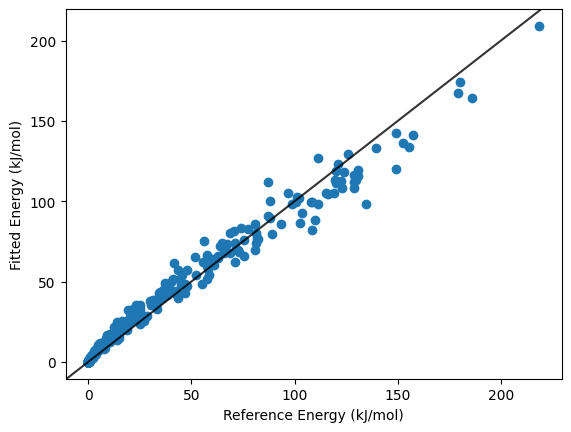

In [22]:
import matplotlib.pyplot as plt
plt.xlabel("Reference Energy (kJ/mol)")
plt.ylabel("Fitted Energy (kJ/mol)")
plt.axline((0, 0), slope=1, linewidth=1.5, color="k",alpha=0.8)
plt.scatter(energies_ref, energies)

至此，那我们可以得到一个相当不错的Pauli Exchange相互作用，接着我们可以尝试拟合完整的相互作用。

In [23]:
train_keys = ['SlaterExForce', 'SlaterSrEsForce', 'SlaterSrPolForce', \
                'SlaterSrDispForce', 'SlaterDhfForce', 'QqTtDampingForce', 'SlaterDampingForce']

del_lr_keys = ['ADMPPmeForce', 'ADMPDispPmeForce']

for key in del_lr_keys:
    del pots_AB.dmff_potentials[key]
    del pots_A.dmff_potentials[key]
    del pots_B.dmff_potentials[key]

In [24]:
pots_tot_AB = pots_AB.getPotentialFunc()
pots_tot_A = pots_A.getPotentialFunc()
pots_tot_B = pots_B.getPotentialFunc()
pots_tot_AB_v = jit(vmap(pots_tot_AB, in_axes=(0, None, None, None), out_axes=(0)))
pots_tot_A_v = jit(vmap(pots_tot_A, in_axes=(0, None, None, None), out_axes=(0)))
pots_tot_B_v = jit(vmap(pots_tot_B, in_axes=(0, None, None, None), out_axes=(0)))

In [25]:
@jit
def MSELoss(params, scan_res):
    '''
    The weighted mean squared error loss function
    Conducted for each scan
    '''

    E_ref = scan_res['ex']
    E_tot_full = scan_res['tot_full']
    kT = 2.494 # 300 K = 2.494 kJ/mol
    weights_pts = jnp.piecewise(E_tot_full, [E_tot_full<25, E_tot_full>=25], [lambda x: jnp.array(1.0), lambda x: jnp.exp(-(x-25)/kT)])
    npts = len(weights_pts)

    pos_A = jnp.array(scan_res['posA']) * 0.1
    pos_B = jnp.array(scan_res['posB']) * 0.1
    pos_AB = jnp.concatenate([pos_A, pos_B], axis=1)
    E_AB = pots_tot_AB_v(pos_AB, box, pairs_AB, params)
    E_A = pots_tot_A_v(pos_A, box, pairs_A, params)
    E_B = pots_tot_B_v(pos_B, box, pairs_B, params)
    dE = E_AB - E_A - E_B - E_ref
    MSE = jnp.sum(dE**2 * weights_pts) / jnp.sum(weights_pts)

    return MSE
    
MSELoss_grad = jit(value_and_grad(MSELoss, argnums=(0)))

multiTrans = MultiTransform(params)
multiTrans["QqTtDampingForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["QqTtDampingForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterDampingForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterDampingForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterDhfForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterDhfForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterExForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterExForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterSrDispForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterSrDispForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterSrEsForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterSrEsForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterSrPolForce/A"] = genOptimizer(learning_rate=0.1)
multiTrans["SlaterSrPolForce/B"] = genOptimizer(learning_rate=0.1)
multiTrans.finalize()
grad_transform = optax.multi_transform(multiTrans.transforms, multiTrans.labels)
opt_state = grad_transform.init(params)

In [26]:
# the log file
n_epochs = 50

with open("log", "w") as logfile:
    sids = np.array(list(data.keys()))
    for i_epoch in tqdm(range(n_epochs)):
        np.random.shuffle(sids)
        for sid in sids:
            loss, g = MSELoss_grad(params, data[sid])
            print(loss, file=logfile)
            # print(params["SlaterExForce"]["B"])
            logfile.flush()
            updates, opt_state = grad_transform.update(g, opt_state, params=params)
            params = optax.apply_updates(params, updates)
        with open('params.pickle', 'wb') as ofile:
            pickle.dump(params, ofile)

100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


In [28]:
energies = []
energies_ref = []
for sid in tqdm(data.keys()):
    scan_res = data[sid]
    E_tot_full = scan_res['tot_full']
    kT = 2.494 # 300 K = 2.494 kJ/mol
    weights_pts = jnp.piecewise(E_tot_full, [E_tot_full<25, E_tot_full>=25], [lambda x: jnp.array(1.0), lambda x: jnp.exp(-(x-25)/kT)])
    pos_A = jnp.array(scan_res['posA']) * 0.1
    pos_B = jnp.array(scan_res['posB']) * 0.1
    pos_AB = jnp.concatenate([pos_A, pos_B], axis=1)
    E_AB = pots_tot_AB_v(pos_AB, box, pairs_AB, params)
    E_A = pots_tot_A_v(pos_A, box, pairs_A, params)
    E_B = pots_tot_B_v(pos_B, box, pairs_B, params)
    E_ex = E_AB - E_A - E_B
    E_ref = scan_res['tot']
    npts = len(E_ref)

    for ipt in range(npts):
        if weights_pts[ipt] > 1e-2:
            energies.append(E_ex[ipt])
            energies_ref.append(E_ref[ipt])

energies = np.array(energies)
energies_ref = np.array(energies_ref)


100%|██████████| 50/50 [00:04<00:00, 11.56it/s]


Text(0.95, 0.05, 'RMSD = 6.09 kJ/mol')

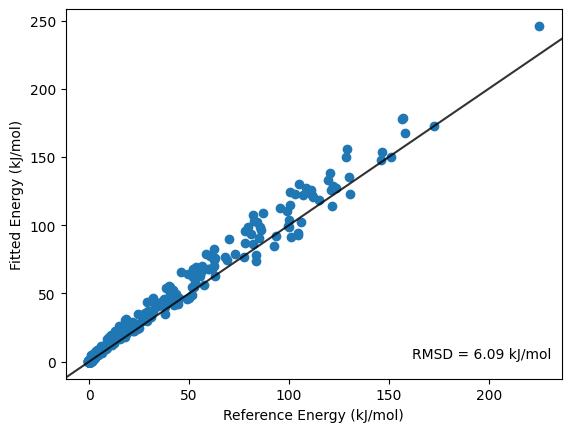

In [29]:
import matplotlib.pyplot as plt

plt.xlabel("Reference Energy (kJ/mol)")
plt.ylabel("Fitted Energy (kJ/mol)")
plt.axline((0, 0), slope=1, linewidth=1.5, color="k",alpha=0.8)
plt.scatter(energies_ref, energies)
rmsd = np.sqrt(np.average((energies - energies_ref)**2))
plt.text(0.95, 0.05, 'RMSD = %.2f kJ/mol' % (rmsd),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

我们可以看到，拟合得到的总能量也十分不错，那我们不妨尝试结构一下不同分量的物理能量，看看是否都能够保持准确。这里我们不再赘述，我直接把PhyNEO Github的结果例子贴在这里，大家可以感受一下。

<img src="https://i.postimg.cc/tgh3kmjJ/test-decomp3.png" width="500" height="auto" />


至此，我们得到了一个完整的非键作用力场，剩下的我们只需要用子图神经网络对成键作用进行拟合即可。

参考论文：
Wang, Xufei, et al. "A scalable graph neural network method for developing an accurate force field of large flexible organic molecules." The Journal of Physical Chemistry Letters 12.33 (2021): 7982-7987.
https://pubs.acs.org/doi/abs/10.1021/acs.jpclett.1c02214

我们采用上述论文中提到的方法来训练sGNN键合能（$E_{\text{sGNN}}^{bond}$），通过OPLS-AA MD采样构象，从总能量中计算并分离出非键作用项。剩余的构象能量被认为是纯键合相互作用，并使用sGNN来描述。

训练数据是使用由PEO[3]小分子在300K和1000K下生成的20000个数据点，90%为训练集，10%为测试集。同样我们也取更长的链PEO[7]为测试集，以此展现sGNN的可拓展性。

In [30]:
#!/usr/bin/env python
import sys
import jax
import time
import jax.numpy as jnp
from jax import grad, value_and_grad, jit
import numpy as np
import dmff
from dmff.sgnn.gnn import MolGNNForce
from dmff.sgnn.graph import TopGraph, from_pdb

import optax
import pickle
# use pytorch data loader
from torch.utils.data import DataLoader

class MolDataSet():

    def __init__(self, pdb, data):
        self.data = data
        self.n_data = len(self.data['positions'])
        self.pdb = pdb
        return

    def __getitem__(self, i):
        return [self.data['positions'][i], self.data['energies'][i]]

    def __len__(self):
        return self.n_data


我们将10000个300K数据点和10000个1000K数据点拆分成18000个点的训练集和2000个点的测试集。
注意这里'energies'标签下的能量为已经扣除过非键作用的能量

In [31]:
restart = None
with open('dataset_train_remove_nb.pickle', 'rb') as ifile:
    data_train = pickle.load(ifile)
with open('dataset_test_remove_nb.pickle', 'rb') as ifile:
    data_test = pickle.load(ifile)

print('train:', parameter_shapes(data_train))
print('test:', parameter_shapes(data_test))

train: {'elements': (1, 30), 'energies': (18000,), 'lr_ff': (18000,), 'positions': (18000, 30, 3), 'sr_ff': (18000,), 'tot_full': (18000,)}
test: {'elements': (1, 30), 'energies': (2000,), 'lr_ff': (2000,), 'positions': (2000, 30, 3), 'sr_ff': (2000,), 'tot_full': (2000,)}


接着我们对数据集进行minibatch的划分

In [32]:
pdb = 'peo3.pdb'
# training and testing data
dataset = MolDataSet(pdb, data_train)
train_loader = DataLoader(dataset, shuffle=True, batch_size=64)
dataset_test = MolDataSet(pdb, data_test)
test_loader = DataLoader(dataset_test, batch_size=500)

sGNN的拓扑建模是基于键的，这里我们进行拓扑建模

In [33]:
box = jnp.eye(3) * 50

# Graph and model
G = from_pdb(pdb)
model = MolGNNForce(G, nn=1)

In [34]:
model.batch_forward = jax.vmap(model.forward, in_axes=(0, None, None), out_axes=(0))

In [35]:
# mean square loss function
def MSELoss(params, positions, box, ene_ref):
    ene = model.batch_forward(positions, box, params)
    err = ene - ene_ref
    # we do not care about constant shifts
    err -= jnp.average(err)
    return jnp.average(err**2)
MSELoss = jit(MSELoss)

In [47]:
# optmizer
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(model.params)

In [49]:
from tqdm import tqdm

# train
best_loss = jnp.array(1e30)
n_epochs = 100
fout=open('nn.err','w')
fout.write("Sub-Graph Nerual Network Package used for intramolecular energy\n")
fout.write(time.strftime("%Y-%m-%d-%H_%M_%S \n", time.localtime()))
fout.flush()
for i_epoch in tqdm(range(n_epochs)):
    # train an epoch
    lossprop = 0
    for ibatch, (pos, e) in enumerate(train_loader):
        pos = jnp.array(pos.numpy())
        ene_ref = jnp.array(e.numpy())
        loss, gradients = value_and_grad(MSELoss, argnums=(0))(model.params, pos, box, ene_ref)
        lossprop += loss
        updates, opt_state = optimizer.update(gradients, opt_state)
        model.params = optax.apply_updates(model.params, updates)
    lossprop = jnp.sqrt(lossprop)
    # print(lossprop)        
    
    if lossprop < best_loss:
        # save model after each epoch
        model.save_params('params_sgnn.pickle') 
        best_loss = lossprop      

        # evaluate test
        ene_refs = []
        ene_preds = []
        for pos, e in test_loader:
            ene_ref = jnp.array(e.numpy())
            pos = jnp.array(pos.numpy())
            ene_pred = model.batch_forward(pos, box, model.params)
            ene_preds.append(ene_pred)
            ene_refs.append(ene_ref)
        ene_ref = jnp.concatenate(ene_refs)
        ene_ref = ene_ref - jnp.average(ene_ref)
        ene_pred = jnp.concatenate(ene_preds)
        ene_pred = ene_pred - jnp.average(ene_pred)
        err = ene_pred - ene_ref
        test_loss = jnp.sqrt(jnp.average(err**2))

        fout.write("{:5} {:4} {:15} {:5e}  {} ".format("Epoch=",i_epoch,"learning rate",lr,"train error:"))
        fout.write('{:10.5f} '.format(lossprop))
        fout.write('{} '.format("test error:"))
        fout.write('{:10.5f} \n'.format(test_loss))
        fout.flush()
        # print test data
        with open('test_data.xvg', 'w') as f:
            print('# RMSE = %10.5f'%test_loss, file=f)
            for e1, e2 in zip(ene_pred, ene_ref):
                print(e2, e2, e1, file=f)
        
fout.write(time.strftime("%Y-%m-%d-%H_%M_%S \n", time.localtime()))
fout.write("terminated normal\n")
fout.close()


100%|██████████| 100/100 [1:58:24<00:00, 71.05s/it]


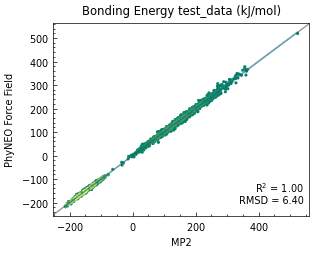

In [50]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import colormaps

from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import sys
import scienceplots

# 设置绘图风格
plt.style.use(['science', 'no-latex', 'nature'])

def plot_data(file):
    dimer = file
    data = np.loadtxt(dimer)
    x = data[:, 0] 
    y1 = data[:, 2]  

    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y1)
    y_pred = model.predict(x.reshape(-1, 1))
    r_squared = model.score(x.reshape(-1, 1), y1)
    rmse_eann = np.sqrt(mean_squared_error(y1, y_pred))

    xy = np.vstack([x, y1])
    z = gaussian_kde(xy)(xy)
    z = preprocessing.maxabs_scale(z, axis=0, copy=True)

    fig, ax = plt.subplots()
    plt.scatter(x, y1, c=z, s=5, edgecolor='none', cmap=colormaps['summer'])
    ax.axline((0, 0), slope=1, linewidth=1.0, color="k", alpha=0.4)
    plt.plot(x, y_pred, linewidth=1.0, color='#279DC4', label='Regression line', alpha=0.4)
    ax.text(0.98, 0.05, 'R$^2$ = %.2f\nRMSD = %.2f' % (r_squared, rmse_eann, ),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes)
    plt.title(f"Bonding Energy {dimer.split('.')[0]} (kJ/mol)")
    plt.ylabel("PhyNEO Force Field")
    plt.xlabel("MP2")
    plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
    # plt.savefig(f"{dimer.split('.')[0]}.png", dpi=600, bbox_inches='tight')
    plt.show()

plot_data('test_data.xvg')

In [51]:
set_file = 'dataset_test_peo7_remove_nb.pickle'
with open(set_file, 'rb') as f:
    data = pickle.load(f)

# training and testing data
box = jnp.eye(3) * 50

# Graph and model
G = from_pdb('peo7.pdb')
model = MolGNNForce(G, nn=1)
model.batch_forward = jax.vmap(model.forward, in_axes=(0, None, None), out_axes=(0))
model.load_params('params_sgnn.pickle')

# evaluate test
ene_preds = model.batch_forward(data['positions'], box, model.params)

ene_pred = np.array(ene_preds).reshape(-1)
ene_ref = data['energies']
ene_pred -= np.average(ene_pred)
ene_ref -= np.average(ene_ref)
n_data = len(ene_ref)
rmsd = np.sqrt(np.average((ene_pred - ene_ref)**2))
print('#', rmsd)
# print test data
with open('test_data_pe16.xvg', 'w') as f:
    print('#', rmsd, file=f)
    for i in range(n_data):
        e1 = ene_pred[i]
        e0 = ene_ref[i]
        print(e0, e0, e1, file=f)

# 7.249215759205433


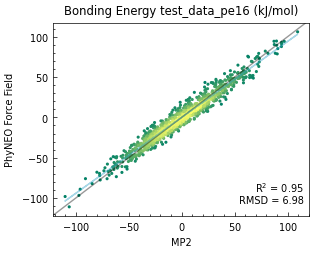

In [52]:
plot_data('test_data_pe16.xvg')